# Search for Cannabis in New NAIP Imagery (Bounding Box)

This notebook loads a trained segmentation model, downloads NAIP imagery for a user-specified bounding box, and searches for signs of cannabis.

In [1]:
import os
import planetary_computer
import pystac_client
import requests

## 1. Load Trained Segmentation Model
Load your trained model checkpoint from cannabis-segmentation-torchgeo.ipynb.

In [2]:
import segmentation_models_pytorch as smp
import torch

model = smp.DeepLabV3Plus(
    encoder_name="resnext50_32x4d",
    encoder_weights=None,
    in_channels=4,
    classes=1
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load("../models/cannabis-segmentation-model.pth", map_location=device))
model.eval()
pass

/var/folders/56/gwh1m3s973l4jc97_wdr2qqw0000gn/T/ipykernel_33559/46873097.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../models/ca

## 2. Specify Bounding Box
Enter the bounding box coordinates (min lon, min lat, max lon, max lat).

In [3]:
# --- User Input for Bounding Box ---
# bbox = [-120.72638195050153, 38.04185830635333, -120.63604314014556, 38.1207676113505]
bbox = [-120.68026045937673,38.075364038625466,-120.67004423250212,38.084287726674845]
print('Using bounding box:', bbox)

Using bounding box: [-120.68026045937673, 38.075364038625466, -120.67004423250212, 38.084287726674845]


## 3. Download NAIP Imagery for Bounding Box
Use Planetary Computer STAC API to search and download NAIP imagery.

In [4]:
# --- Download NAIP Imagery ---
naip_root = '../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set'
time_range = '2016-01-01/2016-12-31'  # or update as needed
catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
search = catalog.search(collections=['naip'], bbox=bbox, datetime=time_range)
items = search.item_collection()
print(f'Found {len(items)} NAIP items for bbox')

# Download imagery
for item in items:
    asset = item.assets['image']
    signed_href = planetary_computer.sign(asset.href)
    out_path = os.path.join(naip_root, os.path.basename(asset.href))
    if not os.path.exists(out_path):
        print(f'Downloading {out_path}')
        r = requests.get(signed_href, stream=True)
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    else:
        print(f'Skipping {out_path} - already exists')


Found 1 NAIP items for bbox
Skipping ../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set/m_3812059_ne_10_h_20160620.tif - already exists


## 4. Preprocess Imagery for Model Inference
Prepare the downloaded NAIP imagery as needed by your model (tiling, normalization, etc).

In [5]:
from torchgeo.datasets import RasterDataset
import rasterio
import re
from datetime import datetime
from pathlib import Path
from rtree import index as rindex
from rasterio.windows import Window
from torchgeo.datasets import BoundingBox

class MicrosoftNaip(RasterDataset):
    def __init__(self, naip_root, transforms=None):
        self.naip_root = Path(naip_root)
        self.filename_glob = "m_*.tif"
        self.filename_regex = r"^.*_.*" # (?P<date>\d{8})" # disable dates for now
        self.date_format = "%Y%m%d"
        self.is_image = True
        self.separate_files = False
        self.all_bands = ("R", "G", "B", "NIR")
        self.rgb_bands = ("R", "G", "B",)
        self.transforms = transforms

        # Build a mapping from ann_path → image_path
        self.image_paths = {}
        for img_path in self.naip_root.glob(self.filename_glob):
            self.image_paths[img_path.stem] = img_path

        super().__init__(paths=self.image_paths.values(), transforms=transforms)

        # set the dates
        dates = []
        for fname in self.image_paths.values():
            match = re.match(r"^.*_(\d{8})", fname.name)
            if match:
                date = datetime.strptime(match.group(1), "%Y%m%d")
                dates.append(date.timestamp())
        if dates:
            self.mint = min(dates)
            self.maxt = max(dates)
        else:
            self.mint = 0
            self.maxt = 9223372036854775807

    def __len__(self):
        return len(self.image_paths)

In [6]:
# Define the sampler with explicit Unit type
from torchgeo.samplers import Units, GridGeoSampler
from torch.utils.data import DataLoader

dataset = MicrosoftNaip(naip_root="../data-to-import/microsoft/naip/calaveras-county-pool-station-rd-inference-set")
print(dataset)

roi = BoundingBox(
    minx=703327.7829248618,
    miny=4216717.824594015,
    maxx=704487.225090172,
    maxy=4217730.5762019735,
    mint=dataset.mint,
    maxt=dataset.maxt,
)


# Define a sampler
tile_size = 256  # Define your tile size
sampler = GridGeoSampler(
    roi=roi,
    dataset=dataset, 
    size=tile_size,
    stride=tile_size
)

def custom_collate_fn(batch):
    """Custom collate function that handles geospatial objects"""
    # Extract items that can be batched normally
    images = []
    filenames = []
    
    for item in batch:
        if "image" in item:
            images.append(item["image"])
        if "filename" in item:
            filenames.append(item["filename"])
    
    # Return a new dictionary with properly batched tensors
    result = {}
    if images:
        result["image"] = torch.stack(images)
    if filenames:
        result["filename"] = filenames
    return result

# Use the custom collate function with DataLoader
dataloader = DataLoader(
    dataset, 
    batch_size=5, 
    sampler=sampler,
    collate_fn=custom_collate_fn
)

MicrosoftNaip Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=697068.0, maxx=708684.0, miny=4208052.0, maxy=4222500.0, mint=0.0, maxt=9.223372036854776e+18)
    size: 4


## 5. Run Model Inference
Apply the segmentation model to the preprocessed imagery.

In [7]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnext50_32x4d",
    encoder_weights="imagenet",
    in_channels=4,
    classes=1
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load("../models/cannabis-segmentation-model.pth", map_location=device))
model.eval()

/var/folders/56/gwh1m3s973l4jc97_wdr2qqw0000gn/T/ipykernel_33559/4108879289.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../models/

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def enhance_contrast(img, low_percentile=2, high_percentile=98):
    """Enhance contrast using percentile stretching - better for aerial imagery."""
    if img.ndim == 3:  # Handle multi-channel images
        out = np.zeros_like(img, dtype=float)
        for i in range(img.shape[-1]):
            p_low, p_high = np.percentile(img[..., i], (low_percentile, high_percentile))
            out[..., i] = np.clip((img[..., i] - p_low) / (p_high - p_low), 0, 1)
        return out
    else:  # Handle single-channel images
        p_low, p_high = np.percentile(img, (low_percentile, high_percentile))
        return np.clip((img - p_low) / (p_high - p_low), 0, 1)

def unnormalize(img, mean, std):
    """Unnormalize a CHW or HWC image array."""
    img = img.copy()
    if img.shape[-1] == len(mean):  # HWC
        img = img * std + mean
    else:  # CHW
        img = (img.transpose(1, 2, 0) * std + mean)
    return np.clip(img, 0, 1)

def show_batch(images, preds=None, mean=None, std=None, bands=(0,1,2), enhance=True):
    """
    Visualize a batch of images, masks, and (optionally) predictions.
    
    Parameters:
    -----------
    images: numpy array (B, C, H, W) or (B, H, W, C)
        Batch of images to visualize
    preds: optional, numpy array
        Predicted masks/labels
    mean, std: optional, arrays of length C
        Normalization parameters for unnormalizing
    bands: tuple
        Which bands to display as RGB (default: 0,1,2)
    enhance: bool
        Whether to apply contrast enhancement (recommended for aerial imagery)
    """
    batch_size = images.shape[0]
    for i in range(batch_size):
        img = images[i]
        
        # Handle unnormalization if needed
        if mean is not None and std is not None:
            img_vis = unnormalize(img, mean, std)
        else:
            img_vis = img.copy()
            if img_vis.shape[0] in [3, 4]:  # CHW to HWC
                img_vis = img_vis.transpose(1, 2, 0)
        
        # Select the specified bands
        if img_vis.shape[-1] >= len(bands):
            img_vis = img_vis[..., list(bands)]
        
        # Ensure values are in a reasonable range for visualization
        if img_vis.max() > 1.1:  # Likely 0-255 range
            img_vis = img_vis / 255.0
            
        # Apply contrast enhancement for aerial imagery
        if enhance:
            img_vis = enhance_contrast(img_vis)

        # Create plot
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_vis)
        plt.title(f"Image {i+1} (Bands {bands})")
        plt.axis("off")

        if preds is not None:
            pred_mask = preds[i]
            if pred_mask.ndim == 3 and pred_mask.shape[0] == 1:
                pred_mask = pred_mask[0]  # Remove channel dim if single-channel
                
            plt.subplot(1, 2, 2)
            plt.imshow(pred_mask, cmap="viridis")
            plt.title("Predicted Mask")
            plt.axis("off")
            
            # Add colorbar for predictions
            plt.colorbar(fraction=0.046, pad=0.04)
            
        plt.tight_layout()
        plt.show()

## 6. Visualize Results
Display detected cannabis areas on the imagery.

Image shape: torch.Size([5, 4, 256, 256])
Image min: 13.0, max: 213.0, mean: 93.36091613769531
Unique values: [ 13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 18

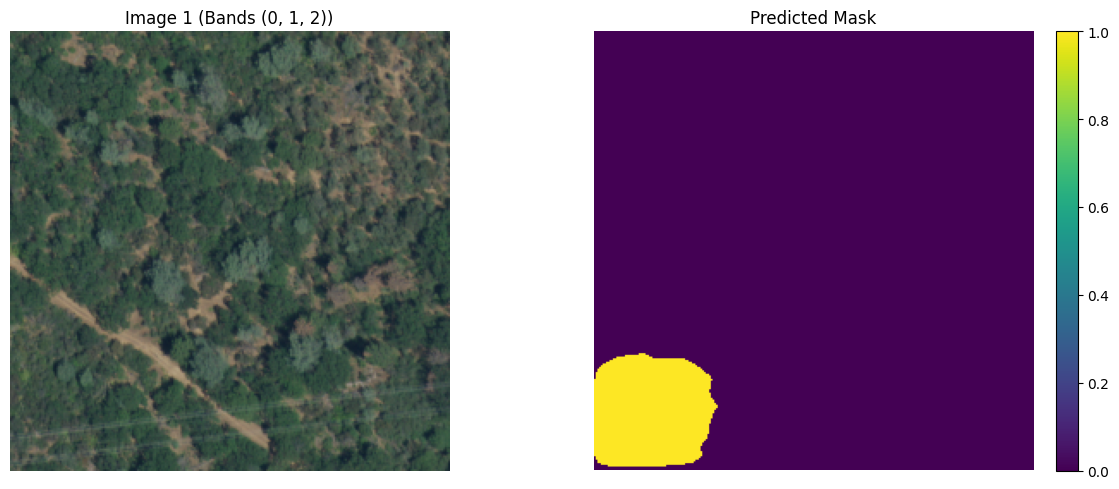

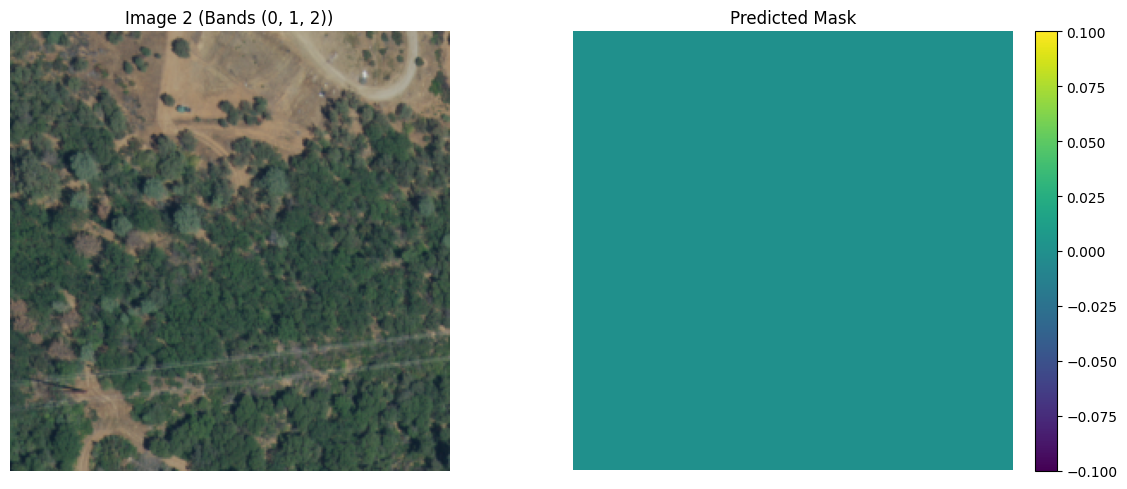

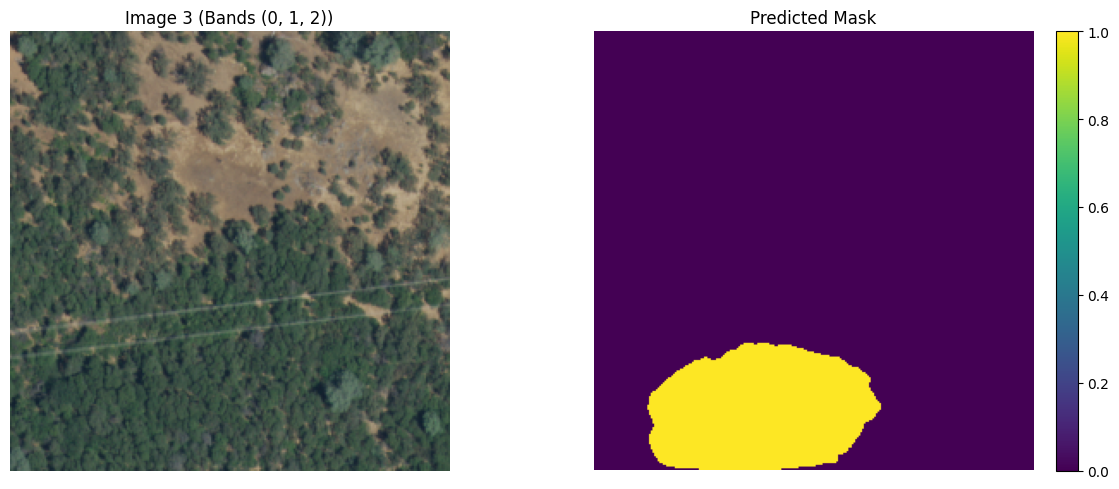

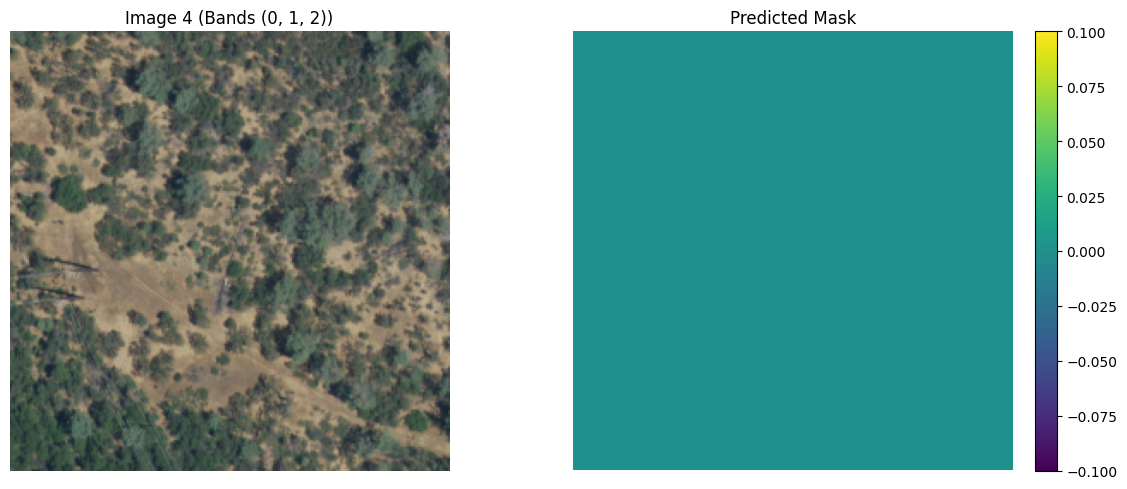

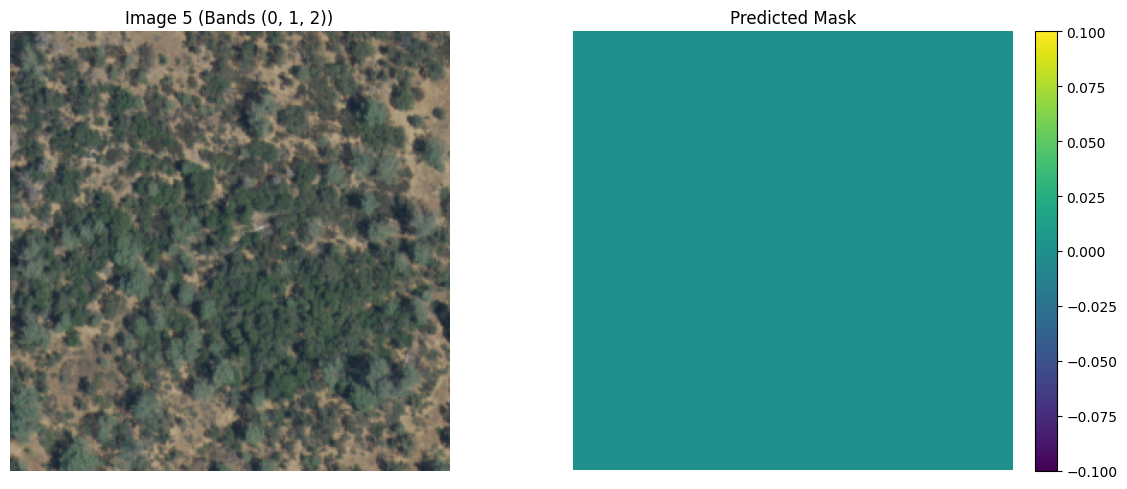

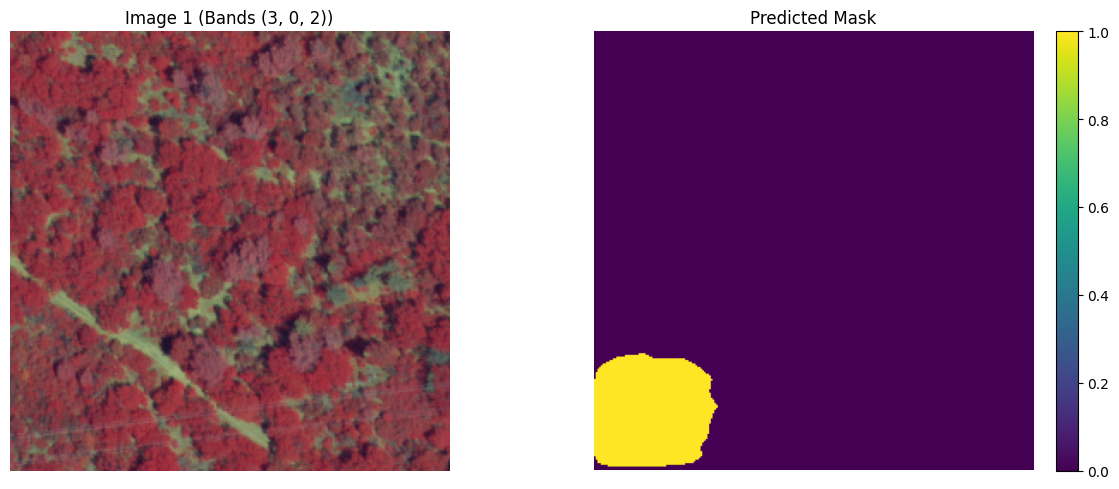

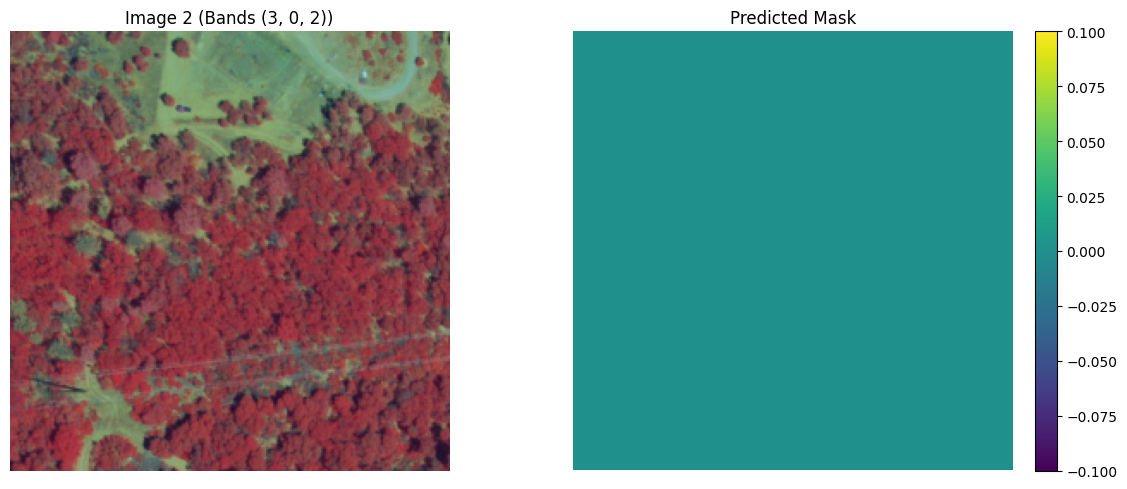

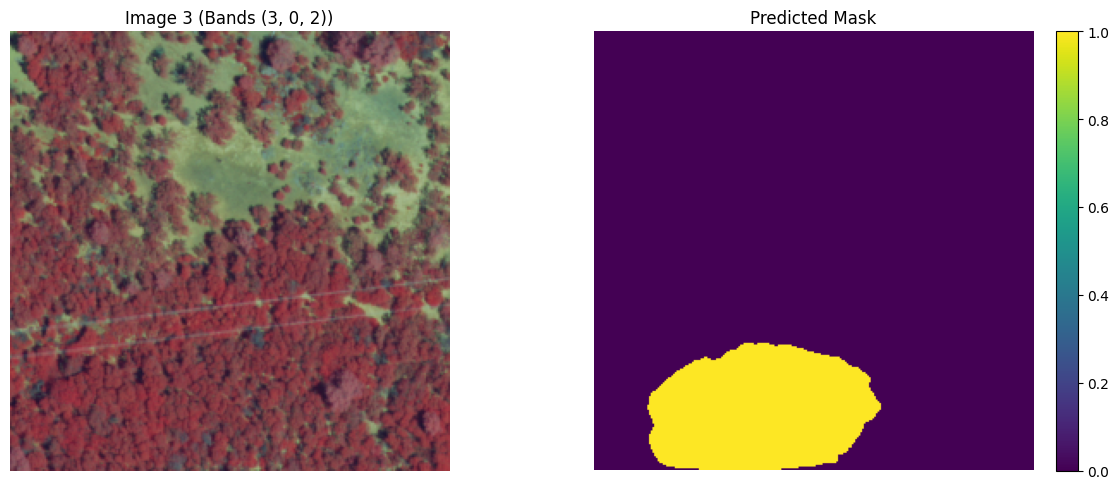

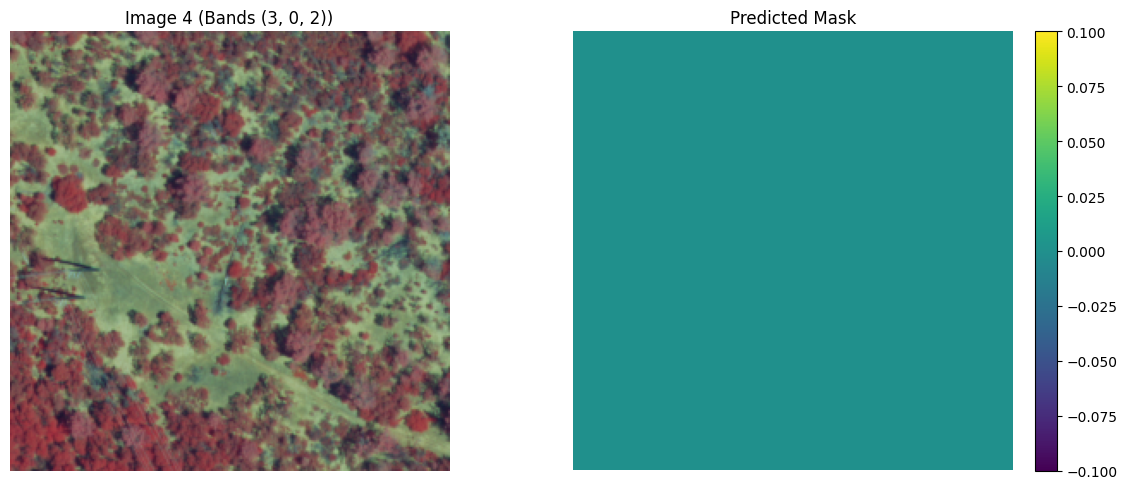

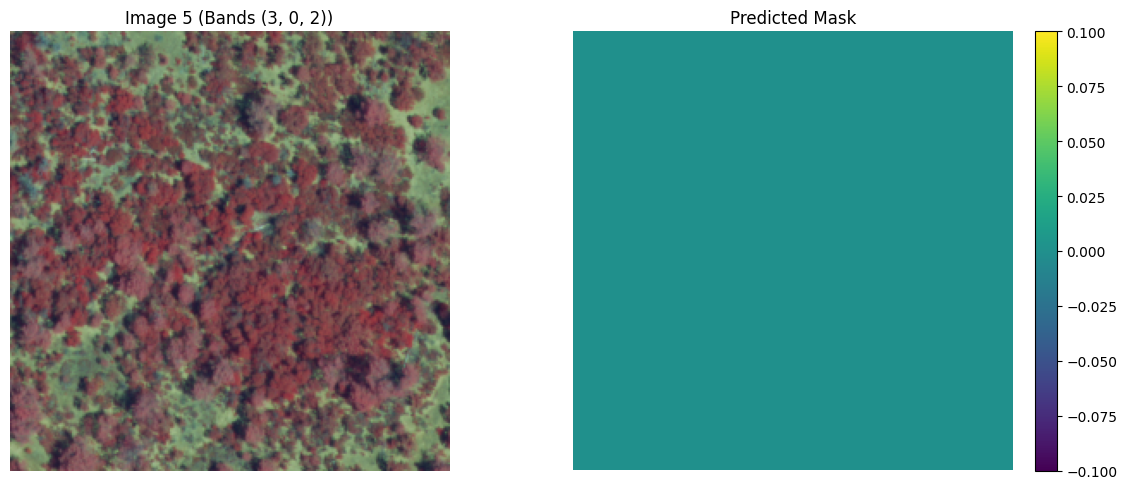

In [11]:
# Get a batch from your validation
batch_data = next(iter(dataloader))

# Extract the image tensor from the dictionary
images = batch_data["image"]

# Make sure image has batch dimension [B,C,H,W]
if images.ndim == 3:  # If single image [C,H,W]
    images = images.unsqueeze(0)  # Add batch dimension [1,C,H,W]

# Add debugging for the raw image values
print(f"Image shape: {images.shape}")
print(f"Image min: {images.min().item()}, max: {images.max().item()}, mean: {images.mean().item()}")
print(f"Unique values: {torch.unique(images).cpu().numpy()}")

# Run inference
with torch.no_grad():
    # Normalize before passing to model (but keep original for visualization)
    images_norm = images.float() / 255.0
    
    outputs = model(images_norm)  # Now passing tensor, not dict
    preds = (outputs > 0.5).float()

# Visualize using the helper function
images_np = images.cpu().numpy()  # Use unnormalized images for better visualization
preds_np = preds.cpu().numpy()

# Don't pass mean/std since we're using the original image data and will apply contrast enhancement
show_batch(
    images_np, 
    preds_np, 
    bands=(0,1,2),   # RGB bands
    enhance=False,    # Apply contrast enhancement
    mean=None,       # Don't use ImageNet normalization
    std=None
)

# If you want to visualize with NIR included (false color)
if images_np.shape[1] >= 4:  # If we have NIR channel
    show_batch(
        images_np,
        preds_np,
        bands=(3,0,2),  # NIR, Red, Blue (false color highlights vegetation)
        enhance=False,
        mean=None,
        std=None,
        )